# Prepare Data
Here we prepare data as 1 min level kline for BTC from 2019.1.1 to 2020.5.2 in bitfinex exchange

In [1]:
#!python3 -m pip install -e .. -U
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm, trange

In [2]:
TZ = 'Asia/Shanghai'

In [3]:
data_path = './data/data'
data_platform_list = ['BITFINEX']
data_symbol_list = ['BTC']

data_df_list = []

In [4]:
for platform in data_platform_list:
    for symbol in data_symbol_list:
        pkl_file_path = data_path+'/'+symbol+'_USD_'+platform+'_latest.pkl'
        pandas_df = pd.read_pickle(pkl_file_path)
        #data_df_list.append(pkl_file.add_prefix(platform+'_'+symbol+':'))
        data_df_list.append(pandas_df)
data = pd.concat(data_df_list, axis=1)

# Feature Enginnering

Tactical indicators etc.

In [5]:
data['timestamp'] = data.index.tolist()

In [6]:
data

,open,high,low,close,volume,timestamp
2019-01-01 16:00:00+08:00,3850.000000,3850.000000,3849.600000,3849.600000,0.443293,2019-01-01 16:00:00+08:00
2019-01-01 16:01:00+08:00,3849.500000,3853.000000,3849.400000,3853.000000,9.085920,2019-01-01 16:01:00+08:00
2019-01-01 16:02:00+08:00,3853.000000,3857.000000,3852.960000,3853.200000,8.213360,2019-01-01 16:02:00+08:00
2019-01-01 16:03:00+08:00,3853.000000,3853.100000,3851.200000,3852.200000,6.385190,2019-01-01 16:03:00+08:00
2019-01-01 16:04:00+08:00,3852.200000,3852.300000,3852.200000,3852.300000,0.504622,2019-01-01 16:04:00+08:00
...,...,...,...,...,...,...
2020-11-07 15:55:00+08:00,15428.349581,15437.000000,15428.000000,15436.374894,1.040375,2020-11-07 15:55:00+08:00
2020-11-07 15:56:00+08:00,15434.000000,15447.000000,15434.000000,15443.000000,5.073000,2020-11-07 15:56:00+08:00
2020-11-07 15:57:00+08:00,15441.000000,15446.000000,15441.000000,15446.000000,1.608000,2020-11-07 15:57:00+08:00
2020-11-07 15:58:00+08:00,15443.786243,15443.786243,15430.460723,15430.460723,0.692501,2020-11-07 15:58:00+08:00


In [7]:
# Prepare features
import talib

# Moving averages
data['ma5m'] = talib.MA(data['close'], timeperiod = 5) / data['close'] 
data['ma10m'] = talib.MA(data['close'], timeperiod = 10) / data['close'] 
data['ma1h'] = talib.MA(data['close'], timeperiod = 60) / data['close'] 
data['ma4h'] = talib.MA(data['close'], timeperiod = 240) / data['close'] 
data['ma12h'] = talib.MA(data['close'], timeperiod = 720) / data['close'] 
data['ma1d'] = talib.MA(data['close'], timeperiod = 1440) / data['close']
data['ma5d'] = talib.MA(data['close'], timeperiod = 7200) / data['close'] 
data['ma10d'] = talib.MA(data['close'], timeperiod = 14400) / data['close'] 
data['ma30d'] = talib.MA(data['close'], timeperiod = 43200) / data['close'] 


# Standard deviation
data['std5m'] = talib.STDDEV(data['close'], timeperiod=5)/ data['close'] 
data['std10m'] = talib.STDDEV(data['close'], timeperiod = 10) / data['close'] 
data['std1h'] = talib.STDDEV(data['close'], timeperiod = 60) / data['close'] 
data['std4h'] = talib.STDDEV(data['close'], timeperiod = 240) / data['close'] 
data['std12h'] = talib.STDDEV(data['close'], timeperiod = 720) / data['close'] 
data['std1d'] = talib.STDDEV(data['close'], timeperiod = 1440) / data['close']
data['std5d'] = talib.STDDEV(data['close'], timeperiod = 7200) / data['close'] 
data['std10d'] = talib.STDDEV(data['close'], timeperiod = 14400) / data['close'] 
data['std30d'] = talib.STDDEV(data['close'], timeperiod = 43200) / data['close'] 

# Closeness to hundred / thousand
data['dis100'] = (data['close'] % 100) / 100 
data['dis1000'] = (data['close'] % 1000) / 1000 

In [8]:
feature_set = ['ma5m','ma10m','ma1h','ma4h','ma12h','ma1d','ma5d','ma10d','ma30d', \
               'std5m','std10m','std1h','std4h','std12h','std1d','std5d','std10d','std30d',\
               'dis100', 'dis1000']

## Augment with same features in previous timestamps

In [9]:
new_feature_set = []
for feature in feature_set:
    data[f'{feature}_p1h'] = data[feature].shift(60)
    data[f'{feature}_p1d'] = data[feature].shift(1440)
    data[f'{feature}_p5d'] = data[feature].shift(7200)
    new_feature_set += [feature, f'{feature}_p1h', f'{feature}_p1d', f'{feature}_p5d']
feature_set = new_feature_set

In [10]:
print(f'Total feature number {len(feature_set)}')

Total feature number 80


## Show distribution of return in 1d 

(array([9.00000e+00, 5.60000e+01, 3.20000e+02, 1.95000e+02, 5.63000e+02,
        1.26600e+03, 3.88500e+03, 5.75400e+03, 1.41590e+04, 4.26120e+04,
        1.28025e+05, 3.82767e+05, 2.44936e+05, 6.97350e+04, 2.83680e+04,
        8.85600e+03, 6.13100e+03, 3.09700e+03, 1.18700e+03, 2.61000e+02,
        2.04000e+02, 1.23000e+02, 1.93000e+02, 2.68000e+02, 1.59000e+02,
        1.02000e+02, 9.70000e+01, 9.90000e+01, 6.60000e+01, 6.70000e+01,
        4.30000e+01, 8.80000e+01, 5.00000e+01, 3.00000e+01, 2.20000e+01,
        1.20000e+01, 1.00000e+01, 4.10000e+01, 4.10000e+01, 4.00000e+01,
        1.10000e+01, 3.00000e+00, 2.00000e+00, 4.00000e+00, 1.20000e+01,
        9.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([-0.28686676, -0.26269117, -0.23851558, -0.21433999, -0.19016441,
        -0.16598882, -0.14181323, -0.11763764, -0.09346206, -0.06928647,
        -0.04511088, -0.0209353 ,  0.00324029,  0.02741588,  0.05159147,
         0.07576705,  0.09994264,  0.12411823,  0

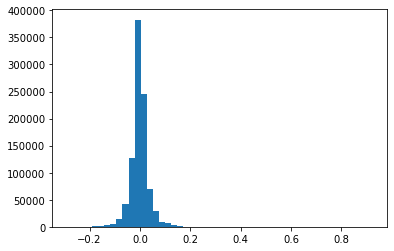

In [11]:
plt.hist(data['close'] / data['close'].shift(-1440) - 1,bins=50)

In [12]:
data['up_x%_in_1d_label'] = 100 * (data['close'] / data['close'].shift(-60) - 1)

In [13]:
data=data.dropna()

## Data Preparation

In [14]:
train_start_time = pd.Timestamp('2019-01-01', tz=TZ)
train_end_time = pd.Timestamp('2019-12-31', tz=TZ)
val_start_time = pd.Timestamp('2020-01-01', tz=TZ)
val_end_time = pd.Timestamp('2020-06-01', tz=TZ)
test_start_time = pd.Timestamp('2020-06-01', tz=TZ)
test_end_time = pd.Timestamp('2020-11-01', tz=TZ)

train_data = data.loc[train_start_time:train_end_time]
val_data = data.loc[val_start_time:val_end_time]
test_data = data.loc[test_start_time:test_end_time]

## Discritize continuous features

In [15]:
X_train = train_data[feature_set].values.squeeze().astype(np.float32)
X_val = val_data[feature_set].values.squeeze().astype(np.float32)
X_test = test_data[feature_set].values.squeeze().astype(np.float32)

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(X_train)

KBinsDiscretizer(encode='ordinal', strategy='uniform')

In [18]:
X_train = est.transform(X_train)
X_val = est.transform(X_val)
X_test = est.transform(X_test)

## Construct labels

In [19]:
label = ['up_x%_in_1d_label']

positive_threshold = 1

#Train
y_train = (train_data[label].values > positive_threshold).astype(int)
y_train_soft = np.zeros((len(y_train),2))
y_train_soft[:,1] = np.clip(1 + train_data[label].values.squeeze() - positive_threshold, 0, 1)
y_train_soft[:,0] = 1 - y_train_soft[:,1]

#Val
y_val = (val_data[label].values > positive_threshold).astype(int)
y_val_soft = np.zeros((len(y_val),2))
y_val_soft[:,1] = np.clip(1 + val_data[label].values.squeeze() - positive_threshold, 0, 1)
y_val_soft[:,0] = 1 - y_val_soft[:,1]

#Test
y_test = (test_data[label].values > positive_threshold).astype(int)
y_test_soft = np.zeros((len(y_test),2))
y_test_soft[:,1] = np.clip(0.5 + (test_data[label].values.squeeze()-positive_threshold), 0, 1)
y_test_soft[:,0] = 1 - y_test_soft[:,1]

In [20]:
print(f'Positive ratio in train set: {np.sum(y_train) / y_train.size}')
print(f'Positive ratio in val set: {np.sum(y_val) / y_val.size}')
print(f'Positive ratio in test set: {np.sum(y_test) / y_test.size}')

Positive ratio in train set: 0.045081318681318684
Positive ratio in val set: 0.05734429648496258
Positive ratio in test set: 0.01931468867245056


## Helper function

In [21]:
def plot_roc_from_fpr_tpr(fpr, tpr):
    lw = 2
    roc_auc = auc(fpr, tpr)
    #plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.3f)' % (roc_auc))
    #plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
    #plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

# Dataset and Dataloader (PyTorch)

In [22]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        'Initialization'
        self.data = torch.from_numpy(data)
        self.labels = torch.from_numpy(labels.squeeze())

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

In [23]:
params = {'batch_size': 1024,
          'shuffle': True,
          'num_workers': 6,
          'pin_memory': True,
        }

In [24]:
train_set = Dataset(X_train, y_train)
train_set_soft = Dataset(X_train, y_train_soft)
train_loader = torch.utils.data.DataLoader(train_set, **params)
train_loader_soft = torch.utils.data.DataLoader(train_set_soft, **params)

val_set = Dataset(X_val, y_val)
val_set_soft = Dataset(X_val, y_val_soft)
val_loader = torch.utils.data.DataLoader(val_set, **params)
val_loader_soft = torch.utils.data.DataLoader(val_set_soft, **params)

test_set = Dataset(X_test, y_test)
test_set_soft = Dataset(X_test, y_test_soft)
test_loader = torch.utils.data.DataLoader(test_set, **params)
test_loader_soft = torch.utils.data.DataLoader(test_set_soft, **params)

# MLP Model (PyTorch)

In [25]:
# define "soft" cross-entropy with pytorch tensor operations
class softXEnt(nn.Module):
    def __init__(self):
        super(softXEnt, self).__init__()

    def forward (self, input, target):
        logprobs = torch.nn.functional.log_softmax (input, dim = 1)
        return  -(target * logprobs).sum() / input.shape[0]

In [26]:
class Net(nn.Module):
    def __init__(self, num_inputs, action_space, hidden_size1=8, hidden_size2=8):
        super(Net, self).__init__()
        self.action_space = action_space
        num_outputs = action_space

        self.linear1 = nn.Linear(num_inputs, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, num_outputs)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)

    def forward(self, inputs):
        x = inputs
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        out = self.linear3(x)

        return out

In [27]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    
    label_gt = []
    label_pred = []
    label_pred_score = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * len(output)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            if len(target.shape) > 1:
                target = target.argmax(dim=1, keepdim=False)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            label_gt += list(target.cpu().numpy())
            label_pred += list(pred.cpu().numpy())
            label_pred_score += list(output[:,1].cpu().numpy())

    test_loss /= len(test_loader.dataset)

    accuracy = correct / len(test_loader.dataset)
        
    
    fpr, tpr, _ = roc_curve(label_gt, label_pred_score)
    roc_auc = auc(fpr, tpr) 
    
    return (test_loss, accuracy, roc_auc, fpr, tpr)

In [28]:
X_train.shape

(455000, 80)

# Training

In [29]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
input_dim = X_train.shape[1]
output_dim = 2
max_epochs = 10

/home/jjyang/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Train with Hard Labels

In [82]:
model = Net(input_dim, output_dim).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
#criterion = softXEnt().to(device)
criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_roc_auc_list = []
val_roc_auc_list = []


max_epochs = 3
for epoch in tqdm(range(max_epochs)):
    train(model, device, train_loader, criterion, optimizer, epoch)
    (train_loss, train_accuracy, train_roc_auc, train_fpr, train_tpr) = test(model, device, train_loader, criterion)
    (val_loss, val_accuracy, val_roc_auc, val_fpr, val_tpr) = test(model, device, val_loader, criterion)
    train_roc_auc_list.append(train_roc_auc)
    val_roc_auc_list.append(val_roc_auc)
    scheduler.step()

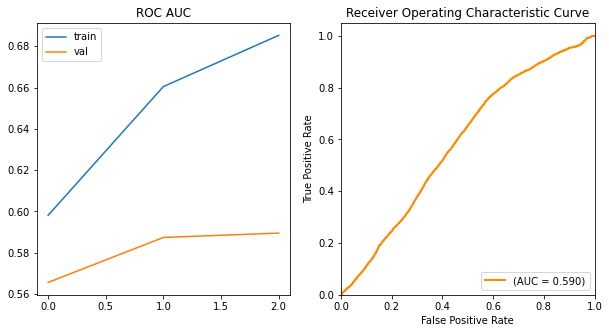

In [55]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(train_roc_auc_list)
plt.plot(val_roc_auc_list)
plt.title('ROC AUC')
plt.legend(['train','val'])
plt.subplot(1, 2, 2)
plot_roc_from_fpr_tpr(val_fpr, val_tpr)

## Train with Soft Labels

In [31]:
model = Net(input_dim, output_dim).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
criterion = softXEnt().to(device)
#criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_roc_auc_list = []
val_roc_auc_list = []

max_epochs = 3
for epoch in tqdm(range(max_epochs)):
    train(model, device, train_loader_soft, soft_criterion, optimizer, epoch)
    (train_loss, train_accuracy, train_roc_auc, train_fpr, train_tpr) = test(model, device, train_loader, criterion)
    (val_loss, val_accuracy, val_roc_auc, val_fpr, val_tpr) = test(model, device, val_loader, criterion)
    train_roc_auc_list.append(train_roc_auc)
    val_roc_auc_list.append(val_roc_auc)
    scheduler.step()

RuntimeError: The size of tensor a (1024) must match the size of tensor b (2) at non-singleton dimension 1

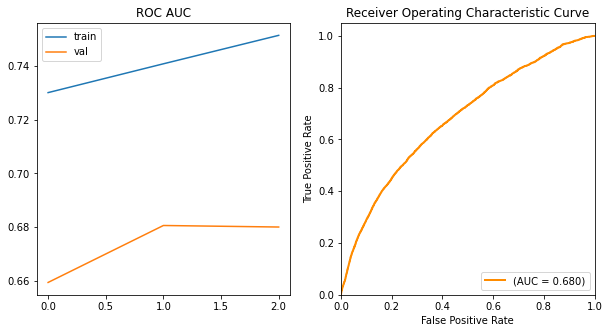

In [57]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(train_roc_auc_list)
plt.plot(val_roc_auc_list)
plt.title('ROC AUC')
plt.legend(['train','val'])
plt.subplot(1, 2, 2)
plot_roc_from_fpr_tpr(val_fpr, val_tpr)

# TODO

## Define model and hyperparameter

In [26]:
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier

### Initialize Sample Reweighting & Feature Selection

In [27]:
from sample_reweight import SampleReweight
from featureSelection import featureSelection

In [28]:
LIMITED_SAMPLE = True
EXAMPLES = 40000 if LIMITED_SAMPLE else X_train.shape[0]

# number of submodels
K = 5

# initialize sample weights and parameters
w = np.ones(X_train.shape[0])[:EXAMPLES]

ALPHA_1 = 1
ALPHA_2 = 1
NUM_BINS = 10
GAMMA = 0.9

# initialize feature selection parameters
NUM_BINS_FS = 3
ratio = [0.8, 0.6, 0.4]
feature_selected = np.arange(len(feature_set))

### Define model

In [29]:
clfs = [GradientBoostingClassifier(random_state=0) for i in range(K)]

### Train Sub-model Loops

In [30]:
try:
    from tqdm import tqdm
    submodels = tqdm(clfs)
except ImportError:
    submodels = clfs

list_feature_selected = []
list_feature_selected.append(feature_selected.copy())
for model in submodels:
    model.fit(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES], sample_weight=w)
    
    staged_pred = []
    
    for i, pred in enumerate(model.staged_predict_proba(X_train[:EXAMPLES, feature_selected])):
        staged_pred.append(np.log(pred))
    # initialize sample reweighting
    SR = SampleReweight(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES], a1=ALPHA_1, a2=ALPHA_2, b=NUM_BINS, gamma=GAMMA)
    w = SR.reweight(model, staged_pred)
    print(np.max(w))

    # feature selection
    feature_selected_index = featureSelection(model, X_val[:EXAMPLES, feature_selected], y_val[:EXAMPLES], NUM_BINS_FS, ratio)
    feature_selected = feature_selected[feature_selected_index]
    print(feature_selected)
    list_feature_selected.append(feature_selected.copy())

  0%|          | 0/5 [00:00<?, ?it/s]/home/jjyang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


16.38209567180732


 20%|██        | 1/5 [00:13<00:55, 13.88s/it]

[5.99946819e-03 4.90964106e-04 0.00000000e+00 0.00000000e+00
 1.74013912e-02 1.17073780e-03 4.84629461e-03 0.00000000e+00
 1.62209439e-01 7.34807486e-02 0.00000000e+00 9.02627384e-03
 7.01504981e-02 0.00000000e+00 4.15872987e-01 0.00000000e+00
 3.10345480e-02 1.77387352e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.27311142e-03 0.00000000e+00 7.43717435e-03 6.49303124e-03
 2.33163345e-03 3.57673869e-01 0.00000000e+00 1.56048770e-02
 1.35229848e-01 0.00000000e+00 0.00000000e+00 6.54743951e-01
 9.93576853e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.72565393e-02 0.00000000e+00 0.00000000e+00
 6.11162878e-03 3.69917958e-03 0.00000000e+00 0.00000000e+00
 6.28326957e-03 0.00000000e+00 0.00000000e+00 8.50328332e-07
 9.79368207e-03 4.30488836e-03 3.25725241e-03 0.00000000e+00
 1.97569629e-01 1.19172425e-01 0.00000000e+00 1.15520312e-01
 4.24265406e-02 1.63224143e-02 3.49005582e-05 2.88629562e-01
 1.15870285e-05 5.244716

/home/jjyang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


50.37081260744911


 40%|████      | 2/5 [00:21<00:35, 11.99s/it]

[0.0005571  0.         0.03188762 0.         0.16737892 0.
 0.01232135 0.05400663 0.37821693 0.         0.05733178 0.02771736
 0.         0.0040956  0.01551714 0.11824168 0.02271209 0.35927764
 0.         0.02097344 0.02104431 0.         0.00355685 0.
 0.00160098 0.         0.         0.00435566 0.         0.03207179
 0.00104014 0.13661233 0.13474273 0.03541887 0.         0.
 0.37504833 0.03723811 0.06762602 0.0061906  0.24217455 0.20536616
 0.15962316 0.09615634 0.33930914 0.03434643 0.06992702 0.18235689]
[ 8 36 17 44 40 41 47  4 42 31 32 15 43 46 38 10  7 37 33 45 29  2 11 16
 20 19 14  6 39 27 13 22 24 30  0 12 18 21  9 25 26 28  5 34  3 35  1 23]
[ 3  8 11 12 14 19 26 29 30 31 32 33 36 45 54 56 59 61 63 64 69 71 72 73
 74 75 76 77 79]


/home/jjyang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


14.276412310818015


 60%|██████    | 3/5 [00:26<00:19,  9.83s/it]

[0.         0.31702862 0.04526601 0.05786058 0.50114392 0.00540824
 0.06986827 0.40641366 0.         0.07765652 0.         1.15417661
 0.12468538 0.03241113 0.07346352 1.01052579 0.24180778 0.05367624
 3.10934487 0.15213348 0.05882394 0.01001642 0.39500406 0.32159074
 0.27606803 0.20097592 3.07152721 0.03137189 0.36537426]
[18 26 11 15  4  7 22 28 23  1 24 16 25 19 12  9 14  6 20  3 17  2 13 27
 21  5 10  8  0]
[ 3  8 11 12 14 26 29 30 31 33 36 56 63 64 69 71 72 76]


/home/jjyang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


21.855202942497097


 80%|████████  | 4/5 [00:29<00:07,  7.77s/it]

[0.         0.18009714 0.05766925 0.0424864  0.60019092 0.01814543
 0.21841538 0.00443994 0.15142335 0.05923713 0.0088884  0.22699461
 0.93837173 0.44926455 0.49636086 0.33280491 0.27968308 0.95367846]
[17 12  4 14 13 15 16 11  6  1  8  9  2  3  5 10  7  0]
[ 3 11 29 33 56 63 64 69 71 72 76]


/home/jjyang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
100%|██████████| 5/5 [00:30<00:00,  6.08s/it]

10.529383857967561
[ 3 11 29 33 56 63 64 69 71 72 76]


In [31]:
feature_selected

array([ 3, 11, 29, 33, 56, 63, 64, 69, 71, 72, 76])

In [34]:
counter = -1
decision_list = []
for clf in clfs:
    counter += 1
    decision_list.append(clf.decision_function(X_test[:,list_feature_selected[counter]]))
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score = np.mean(np.asarray(decision_list), axis = 0)

#y_score = np.mean(np.asarray([clf.decision_function(X_test) for clf in clfs]), axis=0)
#print([clf.decision_function(X_test) for clf in clfs][1])
print(y_score)

5
(5, 212429)
[-5.85201546 -5.5546834  -6.16998104 ... -5.59946404 -5.70929361
 -4.80380195]


## Evaluate Model

In [36]:
def plot_roc(labels, scores):
    lw = 2
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.3f)' % (roc_auc))
    #plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
    #plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

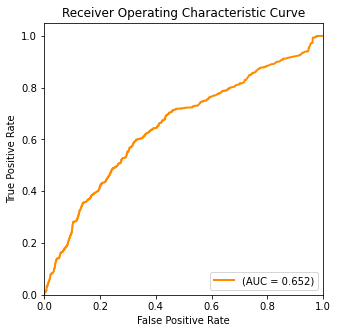

In [37]:
plot_roc(y_test, y_score)